In [1]:
# !pip install vaderSentiment
import tweepy
import json
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

#Import sentiment analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from api_keys import consumer_key, consumer_secret, access_token, access_token_secret
#
analyzer = SentimentIntensityAnalyzer()

In [2]:
#Instantiate Authentication / Wrapper
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

In [3]:
#Observe 5 different Twitter accounts from Major Media
handles = ['BBC', 'CBSNews', 'CNN', 'FoxNews', 'nytimes']

In [4]:
#Create Empty Lists for Tweets
tweets = []
name = []
full_text = []

In [5]:
#Loop through handles and compile last 100 tweets from each
for i in handles:
    tweets = tweepy.Cursor(api.user_timeline, i, tweet_mode='extended').items(100)
    for j in tweets:
        name.append(j.author.name)
        full_text.append(j.full_text)

In [6]:
#Create DataFrame with Tweets
twitter_df = pd.DataFrame({'Name' : name, 'Tweet Text' : full_text})
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)
twitter_df

,Name,Tweet Text
0,BBC,The stories of ordinary people fighting for truth and justice following acts of terror.\n\nIn the Face of Terror starts tonight | 9pm | @BBCTwo &amp; @BBCiPlayer.\n\n👉 https://t.co/99qI8Q4FEz https://t.co/SGEesNSBjX
1,BBC,"""The currency that we deal in is the most valuable thing on the planet. It's human life.""\n\nBrand new #Surgeons: At the Edge of Life | Starts Tuesday | 9pm | @bbctwo &amp; @bbciplayer. https://t.co/EvEQxmx2At"
2,BBC,"@BBCiPlayer @sueperkins These are Japan’s remarkable free-diving grannies, who dive to depths of 30 feet! \n\n#JapanWithSuePerkins is streaming now on.\n\n@sueperkins\nhttps://t.co/E2hn11BROe"
3,BBC,"From A to ""Oh"" to Z.\n\n#GavinAndStacey | @bbcthree\n\nhttps://t.co/PjHtnwrPNV"
4,BBC,"The #GrahamNorton Show is BACK! 🙌\n\nThis week's star studded line up, both in-studio and connecting remotely...\n\n✨ @DollyParton \n✨#RupertEverett \n✨@LollyAdefope\n✨@rizwanahmed\n✨@SaraPascoe\n✨@RoisinMurphy\n\n👉https://t.co/jLmUhRRKDg https://t.co/EFpACyElKJ"
...,...,...
495,The New York Times,"Cineworld said it would temporarily close all 663 of its movie theaters in the United States and Britain. The move was expected to affect 45,000 employees. https://t.co/DCSllnShx3"
496,The New York Times,"Thomas Jefferson Byrd, a Tony-nominated actor also known for roles in various Spike Lee films, was found shot to death on an Atlanta street, the authorities said Sunday. He was 70. https://t.co/km4Z6SnPkU"
497,The New York Times,"Some of the coronavirus treatments President Trump is receiving would normally be for a more severe case than the White House has disclosed, outside experts say. https://t.co/iNA1XJSM4l"
498,The New York Times,"""I used to actually pray for homework.""\n\nWhen Denisha Smith left home at 14 she slept wherever she could, including friends' houses and subway cars. Her love of school, however, was one constant. She just became a teacher. https://t.co/kwUSZ6mB3V"


In [7]:
#Give each tweet an index # that resets once the name of the handle changes
base_name = twitter_df.loc[0,'Name']
counter = 0 
for index, row in twitter_df.iterrows():
    if row['Name'] == base_name:
        twitter_df.loc[index,'Tweets Ago'] = counter
        counter +=1
    if row['Name'] != base_name:
        counter = 0
        twitter_df.loc[index,'Tweets Ago'] = counter
        base_name = row['Name']
        counter +=1

In [8]:
#Analyze the Sentiment of each Tweet
for index, row in twitter_df.iterrows():
    tweet = row['Tweet Text']
    results = analyzer.polarity_scores(f'{tweet}')
    twitter_df.loc[index, 'Compound'] = results['compound']
    twitter_df.loc[index, 'Positive'] = results['pos']
    twitter_df.loc[index, 'Neutral'] = results['neu']
    twitter_df.loc[index, 'Negative'] = results['neg']
twitter_df.head()

,Name,Tweet Text,Tweets Ago,Compound,Positive,Neutral,Negative
0,BBC,The stories of ordinary people fighting for truth and justice following acts of terror.\n\nIn the Face of Terror starts tonight | 9pm | @BBCTwo &amp; @BBCiPlayer.\n\n👉 https://t.co/99qI8Q4FEz https://t.co/SGEesNSBjX,0.0,-0.5574,0.133,0.651,0.216
1,BBC,"""The currency that we deal in is the most valuable thing on the planet. It's human life.""\n\nBrand new #Surgeons: At the Edge of Life | Starts Tuesday | 9pm | @bbctwo &amp; @bbciplayer. https://t.co/EvEQxmx2At",1.0,0.5256,0.091,0.909,0.000
2,BBC,"@BBCiPlayer @sueperkins These are Japan’s remarkable free-diving grannies, who dive to depths of 30 feet! \n\n#JapanWithSuePerkins is streaming now on.\n\n@sueperkins\nhttps://t.co/E2hn11BROe",2.0,0.5983,0.156,0.844,0.000
3,BBC,"From A to ""Oh"" to Z.\n\n#GavinAndStacey | @bbcthree\n\nhttps://t.co/PjHtnwrPNV",3.0,0.0000,0.000,1.000,0.000
4,BBC,"The #GrahamNorton Show is BACK! 🙌\n\nThis week's star studded line up, both in-studio and connecting remotely...\n\n✨ @DollyParton \n✨#RupertEverett \n✨@LollyAdefope\n✨@rizwanahmed\n✨@SaraPascoe\n✨@RoisinMurphy\n\n👉https://t.co/jLmUhRRKDg https://t.co/EFpACyElKJ",4.0,0.3802,0.082,0.918,0.000


In [9]:
#Create Plot Points for Graphs
x = twitter_df.iloc[0:100,2]
#
bbc = twitter_df.loc[twitter_df['Name']=='BBC']['Compound']
cnn = twitter_df.loc[twitter_df['Name']=='CNN']['Compound']
cbs = twitter_df.loc[twitter_df['Name']== 'CBS News']['Compound']
fox = twitter_df.loc[twitter_df['Name']=='Fox News']['Compound']
nyt = twitter_df.loc[twitter_df['Name']=='The New York Times']['Compound']

No handles with labels found to put in legend.


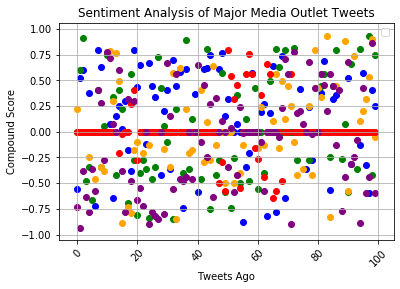

In [10]:
plt.scatter(x,bbc, color = 'blue')
plt.scatter(x,cnn, color = 'green')
plt.scatter(x,cbs, color = 'orange')
plt.scatter(x,fox, color = 'red')
plt.scatter(x,nyt, color = 'purple')
plt.xticks(rotation = 45)
plt.title('Sentiment Analysis of Major Media Outlet Tweets')
plt.xlabel("Tweets Ago")
plt.ylabel("Compound Score")
plt.grid(True)
plt.legend()
plt.savefig('output/tweepy/SentimentbyTweet')

In [11]:
polarity = twitter_df.groupby(['Name']).mean()["Compound"]
pd.DataFrame(polarity)

,Compound
Name,
BBC,0.100738
CBS News,0.021824
CNN,0.016959
Fox News,0.018371
The New York Times,-0.079325


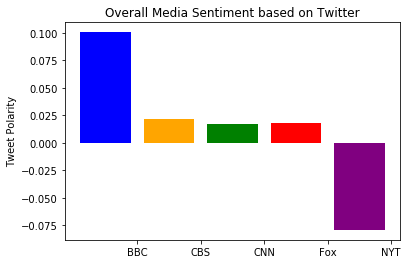

In [12]:
fig, ax = plt.subplots()
x = np.arange(len(polarity))
bbc = ax.bar(x[0], polarity[0], color = 'blue')
cbs = ax.bar(x[1], polarity[1], color = 'orange')
cnn = ax.bar(x[2], polarity[2], color = 'green')
fox = ax.bar(x[3], polarity[3], color = 'red')
nyt = ax.bar(x[4], polarity[4], color = 'purple')
ax.set_ylabel("Tweet Polarity")
ax.set_title("Overall Media Sentiment based on Twitter")
ax.set_xticks(x + 0.5)
ax.set_xticklabels(("BBC", "CBS", "CNN", "Fox", "NYT"))
ax.grid(False)
plt.savefig('output/tweepy/OverallSentiment')

In [13]:
#FoxNews does NOT put text in their tweets - only links to articles. Therefore VADER cannot assign a score